# Bootstrapping

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset and prep
df = pd.read_feather('../data/spotify_2000_2020.feather')
df['is_hit'] = (df['popularity'] > 80).astype(int)


## Step 1: Bootstrapping the Mean Popularity of Hit vs. Non-Hit Songs

We'll estimate the sampling distribution of the mean popularity for:

- Group A: Hit songs (is_hit == 1)

- Group B: Non-hit songs (is_hit == 0)

And compare them using bootstrapped confidence intervals.

### Bootstrap Function + Resampling

In [2]:
# Split data
hit_popularity = df[df['is_hit'] == 1]['popularity'].values
non_hit_popularity = df[df['is_hit'] == 0]['popularity'].values

# Bootstrapping function
def bootstrap_means(data, n_bootstrap=5000):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    return np.array(means)

# Bootstrap samples
boot_hit = bootstrap_means(hit_popularity)
boot_non_hit = bootstrap_means(non_hit_popularity)


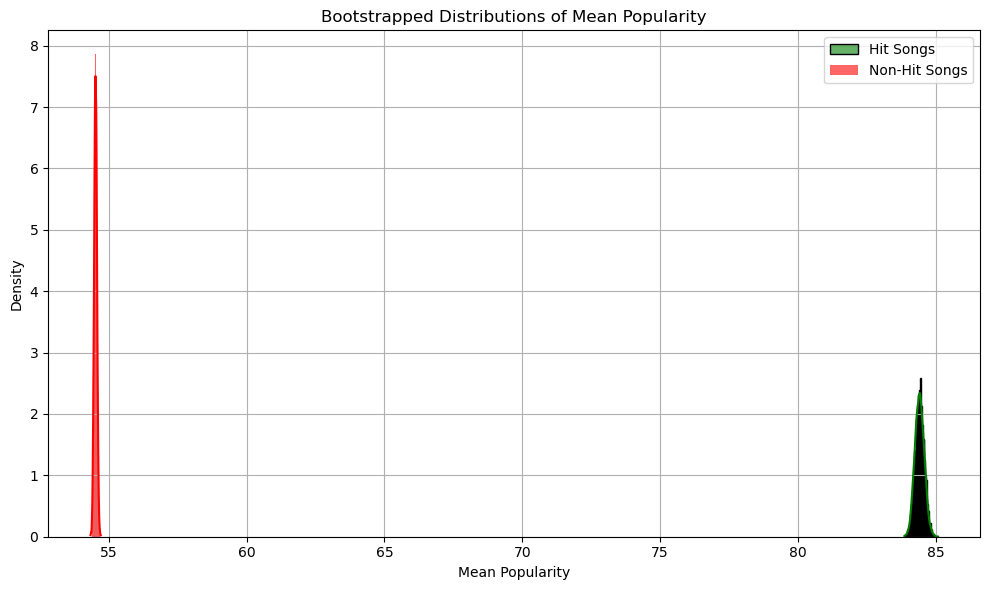

In [3]:
# Plot the bootstrapped means
plt.figure(figsize=(10, 6))
sns.histplot(boot_hit, color='green', label='Hit Songs', kde=True, stat='density', alpha=0.6)
sns.histplot(boot_non_hit, color='red', label='Non-Hit Songs', kde=True, stat='density', alpha=0.6)
plt.title('Bootstrapped Distributions of Mean Popularity')
plt.xlabel('Mean Popularity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🟥 Red curve: Distribution of average popularity from non-hit songs

🟩 Green curve: Distribution of average popularity from hit songs

Each curve shows:

“What the average popularity might look like if we resampled from that group thousands of times.”

#### What This Means

- The green distribution (hits) is centered around ~84–85

- The red distribution (non-hits) is centered around ~54–55

They don’t overlap at all → there's a clear gap between the two groups

- Hit songs have much higher average popularity scores, by definition, but bootstrapping confirms this isn’t random

- The difference in means is stable and statistically meaningful

- This backs up what we saw earlier from hypothesis testing, now shown through distributional comparison

In [4]:
# Confidence intervals
ci_hit = np.percentile(boot_hit, [2.5, 97.5])
ci_non_hit = np.percentile(boot_non_hit, [2.5, 97.5])

print(f"95% CI for Hit Songs: {ci_hit}")
print(f"95% CI for Non-Hit Songs: {ci_non_hit}")

95% CI for Hit Songs: [84.0895977  84.74482759]
95% CI for Non-Hit Songs: [54.42376459 54.62591943]


#### Observation

- The 95% CI for hit songs' mean popularity is **[84.09, 84.74]**  
- For non-hit songs, it's **[54.42, 54.63]**
- These intervals are narrow and **do not overlap**, providing strong evidence that the **average popularity of hit songs is significantly higher** than that of non-hits.
- Bootstrapping confirms and visualizes this difference **without relying on parametric assumptions** like normality.

This supports earlier findings from hypothesis testing with an additional robust estimation method.



## Step 2: Bootstrap the Difference in Means

In [5]:
# Bootstrap difference in means
n_bootstrap = 5000
boot_diffs = []

for _ in range(n_bootstrap):
    sample_hit = np.random.choice(hit_popularity, size=len(hit_popularity), replace=True)
    sample_non_hit = np.random.choice(non_hit_popularity, size=len(non_hit_popularity), replace=True)
    diff = np.mean(sample_hit) - np.mean(sample_non_hit)
    boot_diffs.append(diff)

boot_diffs = np.array(boot_diffs)

# CI for the difference
ci_diff = np.percentile(boot_diffs, [2.5, 97.5])
print(f"95% CI for Mean Difference (Hit - Non-Hit): {ci_diff}")


95% CI for Mean Difference (Hit - Non-Hit): [29.54463422 30.24259721]


- The 95% confidence interval for the **difference in mean popularity** between hit and non-hit songs is:
  **[29.54, 30.24]**
- This means we can be 95% confident that **hit songs are, on average, 29.5 to 30.2 points more popular** than non-hits.
- Since the entire confidence interval is well above zero, this confirms the difference is **both statistically significant and practically meaningful**.
- Bootstrapping gives us this result without any assumption of normality or equal variance, further strengthening our earlier hypothesis testing conclusions.

# One-Way ANOVA: Testing Popularity Differences Across Groups

### 🔬 One-Way ANOVA: Does Explicit Content Affect Popularity?

**Objective:**  
To test whether the average **popularity** of songs differs significantly based on whether a song is **explicit** or not.

**What is One-Way ANOVA?**  
One-way ANOVA (Analysis of Variance) compares the **means of two or more independent groups** to see if at least one group’s mean is significantly different from the others. It is appropriate when:
- The dependent variable is **continuous** (e.g., popularity)
- The independent variable is **categorical** (e.g., explicit vs. non-explicit)
- The groups are **independent** and have roughly equal variance

**Hypotheses:**  
- **H₀ (Null):** There is **no difference** in mean popularity between explicit and non-explicit songs  
- **H₁ (Alt):** There **is a difference** in mean popularity between at least two groups

We’ll apply this to the `explicit` flag in our dataset to determine if explicit content influences a song’s popularity on Spotify.

## Step 1: Explore Group Sizes

In [7]:
# Count songs by explicit flag
df['explicit'].value_counts()

explicit
0.0    32246
1.0     9410
Name: count, dtype: int64

## Step 2: Prepare and Run the ANOVA

In [8]:
from scipy.stats import f_oneway

# Drop missing values in 'explicit' just in case
df_anova = df.dropna(subset=['explicit'])

# Split popularity into groups based on 'explicit' values
group_0 = df_anova[df_anova['explicit'] == 0]['popularity']
group_1 = df_anova[df_anova['explicit'] == 1]['popularity']

# Run one-way ANOVA
f_stat, p_value = f_oneway(group_0, group_1)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")


F-statistic: 1231.0373
p-value: 0.0000


### Interpretation:

- The p-value is far below the 0.05 threshold, so we reject the null hypothesis.

- This means there is a statistically significant difference in the average popularity of explicit vs. non-explicit songs.

- Since there are only two groups, the result is functionally equivalent to a t-test, but this framework will scale when we analyze more categories like genre or year.

## Step 2 Boxplot of Popularity by Explicitness


/tmp/ipykernel_74181/605962029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='explicit', y='popularity', palette='Set2')


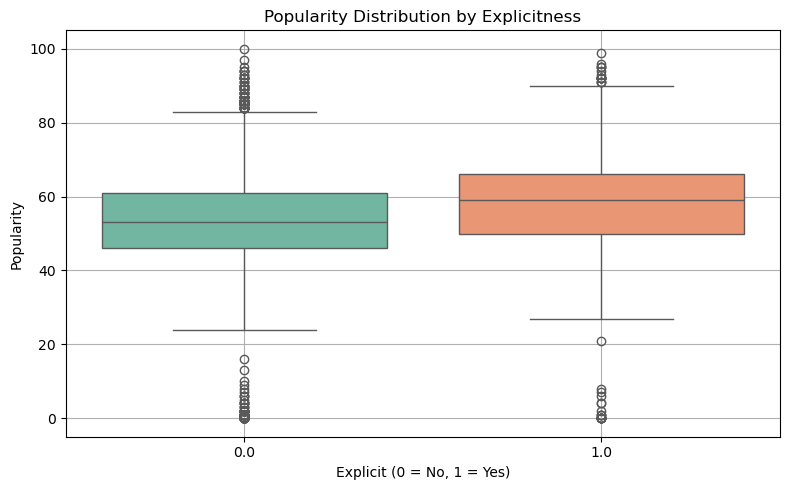

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='explicit', y='popularity', palette='Set2')
plt.title('Popularity Distribution by Explicitness')
plt.xlabel('Explicit (0 = No, 1 = Yes)')
plt.ylabel('Popularity')
plt.grid(True)
plt.tight_layout()
plt.show()
